In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import umap
import glob
import PyPDF2 
from natsort import natsorted 


import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import random
import math

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr
from matplotlib.colors import Normalize
from matplotlib import cm

/home/aabisheva/anaconda3/envs/nmf/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aabisheva/anaconda3/envs/nmf/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aabisheva/anaconda3/envs/nmf/lib/python3.11/site-packages/umap/d

In [2]:
import matplotlib as mpl
from scipy.cluster import hierarchy
from scipy.spatial import distance
from matplotlib.colors import ListedColormap

In [3]:
sys.path.append('/net/seq/data2/projects/aabisheva/Encode/my_ipynb/Vocabulary')
import OONMF
import OONMFhelpers
from OONMFhelpers import get_barsortorder

In [4]:
os.chdir("/net/seq/data2/projects/aabisheva/Encode/my_ipynb/")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")

from matplotlib.cm import get_cmap
cmap = get_cmap('tab10')

/tmp/ipykernel_26369/3438821175.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


In [12]:
def make_stacked_bar_plot_sorted(self, Nrelevant, BarMatrix, bargraph_out, names=[], barsortorder=[], plot_title='', figdim1=150, figdim2=40):
    if len(barsortorder) < 1:
        barsortorder = np.arange(Nrelevant)

    if len(names) < 1:
        names = [str(i) for i in range(Nrelevant)]
        names = np.array(names)

    start = 0
    end = Nrelevant
    Xpositions = np.arange(Nrelevant)

    self.define_colors()

    plt.clf()
    plt.figure(figsize=(figdim1, figdim2))

    for column in range(Nrelevant):
        ground_pSample = 0
        bar_heights = BarMatrix[:, start:end].T[barsortorder][column]
        indices = np.flip(np.argsort(bar_heights))
        # indices = np.arange(self.Ncomps)
        sorted_heights = bar_heights[indices]
        colours = [self.Comp_colors[i] for i in indices]

        for component in range(self.Ncomps):
            plt.bar(Xpositions[column], sorted_heights[component], bottom=ground_pSample, color=colours[component], alpha=1)
            ground_pSample = np.sum(sorted_heights[0:component + 1])

    OONMFhelpers.increase_axis_fontsize()

    plt.ylabel('sum of signal in matrix', fontsize=70)
    if (len(plot_title) > 0):
        plt.title(plot_title)

    samplenamesize = (1 / Nrelevant)**0.5 * 130
    thebottom = min([(1 / Nrelevant)**0.3 * 1.2, 0.3])

    plt.xticks(Xpositions, names[barsortorder], rotation='vertical', fontsize=samplenamesize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=thebottom)

    #plt.savefig(bargraph_out)
    plt.show()
    plt.close()


OONMF.NMFobject.make_stacked_bar_plot_sorted = make_stacked_bar_plot_sorted

In [6]:
def barsortorder_all_components(BarMatrix):
    bar_indices = np.empty(BarMatrix.T.shape)
    for i, bar in enumerate(BarMatrix):
        np.copyto(bar_indices[:, i], np.flip(np.argsort(bar)))
    return np.lexsort(np.flip(bar_indices, 0))

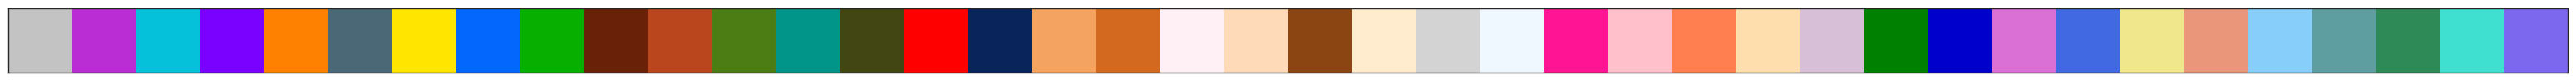

In [7]:
# Just color scheme inicialization

n_components = 40

# code from Waulter's library, to have the similar colors as in barplot
colors_order = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
colors_order = list(np.array(colors_order)[neworder])

if (n_components>len(colors_order)):
    colornames = np.sort(list(mcolors.CSS4_COLORS.keys()))
    count = len(colors_order)
    np.random.seed(10)
    myrandint = np.random.randint(len(colornames))
    while (count < n_components):
        myrandint =    np.random.randint(len(colornames))
        newcolor = colornames[myrandint]
        trialcount = 0
        while ((newcolor in colors_order) and (trialcount < 100)):
            newcolor = colornames[np.random.randint(0,len(colornames))]
            trialcount+=1
        #print('new color ',count,newcolor)
        colors_order.append(newcolor)
        count+=1

# just for checking colors
fig, ax = plt.subplots(figsize=(len(colors_order), 1))

# Draw a rectangle for each color in the list
for i, color in enumerate(colors_order):
    rect = plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='none')
    ax.add_patch(rect)

# Customize the plot
ax.set_xlim(0, len(colors_order))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.show()

In [8]:
dir_path_pipeline = "/net/seq/data2/projects/aabisheva/Encode/nextflow_results/nmf_results/"
dir_path_figures = "/net/seq/data2/projects/aabisheva/Encode/nextflow_results/figures/"
data_slice_size = "full"

In [9]:
def swap_basis_mixture(self):
    self.Basis, self.Mixture = self.Mixture.T, self.Basis.T
    
OONMF.NMFobject.swap_basis_mixture = swap_basis_mixture

In [10]:
def cut_basis(self, row_number):
   # self.Basis = self.Basis[:row_number, :]
    if row_number > len(self.Basis):
        print(f"Requested more rows ({row_number}) than available ({len(self.Basis)})")
        return
    random_indices = np.random.choice(len(self.Basis), size=row_number, replace=False)
    self.Basis = self.Basis[random_indices, :]
    
OONMF.NMFobject.cut_basis = cut_basis

In [60]:
# try again
data_slice_size = "full"
methods_range = ["unweight"]
NC_ar = [16]

for method in methods_range:
    for n_components in NC_ar:
        print("METHOD: ", method, " N_components: ", n_components)
        
        prefix = "bin_new_" + method + "_" + str(data_slice_size)+'.'+ str(n_components)
        
        # Data loading
        decomp = OONMF.NMFobject(n_components)
        decomp.matrix_input_name(dir_path_pipeline + prefix +'.W.npy', 
                                 dir_path_pipeline + prefix +'.H.npy')
        decomp.read_matrix_input(compressed=False)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.swap_basis_mixture()
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.cut_basis(50000)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.normalize_matrices()
        bar_graph_sort_order = get_barsortorder(decomp.Basis)
        decomp.define_colors()

        start_time = time.time()
        # Stacked barplot
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.Basis.T, 
                          dir_path_figures + prefix + '.DHS_random_cut_50000.stacked_bar_plot.pdf', 
                          barsortorder=bar_graph_sort_order)
        
        print("Time to plot: ", time.time() - start_time)        
        bar_graph_sort_order = get_barsortorder(decomp.NormedBasis)
        
        # Normalized stacked barplot
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.NormedBasis.T, 
                          dir_path_figures + prefix + '.DHS_random_cut_50000.stacked_bar_plot.normed.pdf', 
                          barsortorder=bar_graph_sort_order)
        
        # Normalized stacked barplot sorted by same components
        bar_graph_sort_order = barsortorder_all_components(decomp.NormedBasis)        
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.NormedBasis.T, 
                          dir_path_figures + prefix + '.DHS_random_cut_50000_sorted_by_same_components.stacked_bar_plot.normed.pdf', 
                          barsortorder=bar_graph_sort_order)

       
        
        

METHOD:  unweight  N_components:  16
(3780, 16) (16, 4230461) matrixes loaded for n_components 16
(4230461, 16) (16, 3780) matrixes loaded for n_components 16
(50000, 16) (16, 3780) matrixes loaded for n_components 16
Time to plot:  1613.5703346729279


<Figure size 640x480 with 0 Axes>

In [54]:
def take_indicises(self, indices):
    self.Basis = self.Basis[indices]
    
OONMF.NMFobject.take_indicises = take_indicises

In [51]:
indices = np.load('/net/seq/data2/projects/sabramov/SuperIndex/dnase-0520/most_variable_peaks_g_10000_g_2500.npy')

In [61]:
data_slice_size = "full"
methods_range = ["unweight"]
NC_ar = [16]

for method in methods_range:
    for n_components in NC_ar:
        print("METHOD: ", method, " N_components: ", n_components)
        
        prefix = "bin_new_" + method + "_" + str(data_slice_size)+'.'+ str(n_components)
        
        # Data loading
        decomp = OONMF.NMFobject(n_components)
        decomp.matrix_input_name(dir_path_pipeline + prefix +'.W.npy', 
                                 dir_path_pipeline + prefix +'.H.npy')
        decomp.read_matrix_input(compressed=False)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.swap_basis_mixture()
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.take_indicises(indices)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.normalize_matrices()
        bar_graph_sort_order = get_barsortorder(decomp.Basis)
        decomp.define_colors()

        
        # Stacked barplot
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.Basis.T, 
                          dir_path_figures + prefix + '.DHS_most_variable_cut_50000.stacked_bar_plot.pdf', 
                          barsortorder=bar_graph_sort_order)
        
        bar_graph_sort_order = get_barsortorder(decomp.NormedBasis)
        
        # Normalized stacked barplot
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.NormedBasis.T, 
                          dir_path_figures + prefix + '.DHS_most_variable_cut_50000.stacked_bar_plot.normed.pdf', 
                          barsortorder=bar_graph_sort_order)
        
        # Normalized stacked barplot sorted by same components
        bar_graph_sort_order = barsortorder_all_components(decomp.NormedBasis)        
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.NormedBasis.T, 
                          dir_path_figures + prefix + '.DHS_most_variable_cut_50000_sorted_by_same_components.stacked_bar_plot.normed.pdf', 
                          barsortorder=bar_graph_sort_order)

        
        
        

METHOD:  unweight  N_components:  16
(3780, 16) (16, 4230461) matrixes loaded for n_components 16
(4230461, 16) (16, 3780) matrixes loaded for n_components 16
(44566, 16) (16, 3780) matrixes loaded for n_components 16


<Figure size 640x480 with 0 Axes>

In [62]:
# try again
data_slice_size = "full"
methods_range = ["unweight"]
NC_ar = [16]

for method in methods_range:
    for n_components in NC_ar:
        print("METHOD: ", method, " N_components: ", n_components)
        
        prefix = "bin_new_" + method + "_" + str(data_slice_size)+'.'+ str(n_components)
        
        # Data loading
        decomp = OONMF.NMFobject(n_components)
        decomp.matrix_input_name(dir_path_pipeline + prefix +'.W.npy', 
                                 dir_path_pipeline + prefix +'.H.npy')
        decomp.read_matrix_input(compressed=False)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.swap_basis_mixture()
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.cut_basis(500000)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.normalize_matrices()
        bar_graph_sort_order = get_barsortorder(decomp.Basis)
        decomp.define_colors()

        start_time = time.time()
        # Stacked barplot
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.Basis.T, 
                          dir_path_figures + prefix + '.DHS_random_cut_50000.stacked_bar_plot.pdf', 
                          barsortorder=bar_graph_sort_order)
        
        print("Time to plot: ", time.time() - start_time)        
        bar_graph_sort_order = get_barsortorder(decomp.NormedBasis)
        
        # Normalized stacked barplot
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.NormedBasis.T, 
                          dir_path_figures + prefix + '.DHS_random_cut_50000.stacked_bar_plot.normed.pdf', 
                          barsortorder=bar_graph_sort_order)
        
        # Normalized stacked barplot sorted by same components
        bar_graph_sort_order = barsortorder_all_components(decomp.NormedBasis)        
        decomp.make_continuous_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                          decomp.NormedBasis.T, 
                          dir_path_figures + prefix + '.DHS_random_cut_50000_sorted_by_same_components.stacked_bar_plot.normed.pdf', 
                          barsortorder=bar_graph_sort_order)

       
        
        

METHOD:  unweight  N_components:  16
(3780, 16) (16, 4230461) matrixes loaded for n_components 16
(4230461, 16) (16, 3780) matrixes loaded for n_components 16
(500000, 16) (16, 3780) matrixes loaded for n_components 16


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f1b3b88d260> (for post_execute):


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

Error in callback <function flush_figures at 0x7f1b2da9d800> (for post_execute):


KeyboardInterrupt: 

In [30]:
def make_continuous_stacked_bar_plot_sorted(self, Nrelevant, BarMatrix, bargraph_out, names=[], barsortorder=[], plot_title='', figdim1=150, figdim2=40):
    if len(barsortorder) < 1:
        barsortorder = np.arange(Nrelevant)

    if len(names) < 1:
        names = [str(i) for i in range(Nrelevant)]
        names = np.array(names)

    start = 0
    end = Nrelevant
    Xpositions = np.linspace(0, Nrelevant, Nrelevant, endpoint=False)

    self.define_colors()

    plt.clf()
    plt.figure(figsize=(figdim1, figdim2))

    for column in range(Nrelevant):
        ground_pSample = 0
        bar_heights = BarMatrix[:, start:end].T[barsortorder][column]
        indices = np.flip(np.argsort(bar_heights))
        sorted_heights = bar_heights[indices]
        colours = [self.Comp_colors[i] for i in indices]

        for component in range(self.Ncomps):
            plt.fill_between([Xpositions[column], Xpositions[column] + 1], ground_pSample, ground_pSample + sorted_heights[component], color=colours[component])
            ground_pSample = ground_pSample + sorted_heights[component]

    OONMFhelpers.increase_axis_fontsize()

    plt.ylabel('sum of signal in matrix', fontsize=70)
    if (len(plot_title) > 0):
        plt.title(plot_title)

    samplenamesize = (1 / Nrelevant)**0.5 * 130
    thebottom = min([(1 / Nrelevant)**0.3 * 1.2, 0.3])

    plt.xticks(np.arange(0, Nrelevant, step=max(1, Nrelevant//10)), rotation='vertical', fontsize=samplenamesize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=thebottom)
    plt.savefig(bargraph_out)
    #plt.show()
    plt.close()

OONMF.NMFobject.make_continuous_stacked_bar_plot_sorted = make_continuous_stacked_bar_plot_sorted


In [67]:
similar_rows = []

for i in range(decomp.Basis.shape[0]):
    for j in range(i+1, decomp.Basis.shape[0]):
        if np.allclose(decomp.Basis[i], decomp.Basis[j]):
            similar_rows.append((i, j))

print("Indices of similar rows:", len(similar_rows))

KeyboardInterrupt: 

# Sample's plot with new plotting function

In [14]:
with open('/net/seq/data2/projects/sabramov/SuperIndex/dnase-0520/output/indivs_order.txt', 'r') as f:
    sample_names = f.read().strip().split('\t')

# Read the metadata table
metadata_file = '/net/seq/data2/projects/ENCODE4Plus/indexes/index_altius_23-05-11/metadata/ENCODE4plus_master_metadata_for_analysis.tsv'
metadata = pd.read_csv(metadata_file, sep='\t')

# Set 'id' as the index
metadata.set_index('id', inplace=True)

# Filter and reorder the rows based on sample names
metadata = metadata.loc[sample_names]

# Reset the index
metadata.reset_index(inplace=True)

allnames = metadata['taxonomy_name'].to_list()

metadata

,id,tc_number,ds_number,ln_number,passed_agg_qc,hotspot1_spot,hotspot2_spot,nuclear_percent_duplication,taxonomy_name,ontology_id,...,nf_subsampled_spot1,dedupped_subsampled_spot1,dupRate_5M,library_kit,ln,nuclear_aligned,total_aligned,alignment_quality,dhsCounts_AllSamplesIndex,read_depth
0,AG80796,6419,DS12393,LN2503,YES,0.5689,0.4299,21.6078,CMK,EFO:0003037,...,0.5387,0.4431,0.078924,PE,LN2503,32730192.0,60738773.0,0.538868,68501.0,32693071.0
1,AG72371,21827,DS100247,LN82384A,YES,0.5158,0.4065,23.4548,h.HCT116.CDK7,EFO:0002824,...,0.5055,0.4884,0.028639,ThruPLEX DNA-seq Kit,LN82384A,97125448.0,130506912.0,0.744217,65376.0,97056200.0
2,AG81543,1057,DS38746,LN32943A,YES,0.3107,0.2338,5.1937,h.KASUMI-1,EFO:0006607,...,0.3110,0.3027,0.009148,SSlib-JV7Q,LN32943A,70296634.0,127108972.0,0.553042,91619.0,70230350.0
3,AG81555,1054,DS38656,LN32851A,NO,0.2935,0.2035,14.7722,h.KASUMI-1,EFO:0006607,...,0.2939,0.2759,0.030704,SSlib-JV7Q,LN32851A,55472874.0,91384032.0,0.607030,71619.0,55425579.0
4,AG80699,6975,DS14323,LN3036,YES,0.6416,0.4020,18.2760,h.WI-38,EFO:0001260,...,0.6004,0.5361,0.067307,PE,LN3036,24984098.0,34253236.0,0.729394,60925.0,24965490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775,AG6933,7523,DS39312,LN42983C,NO,0.2594,0.1888,12.8734,h.smooth muscle cell,CL:0000192,...,0.2588,0.2524,0.005988,Thruplex DNA-Seq H,LN42983C,242141104.0,293510790.0,0.824982,134383.0,210615155.0
3776,AG80385,6198,DS20493,LN4859,YES,0.6654,0.7099,24.2645,M059J,EFO:0005697,...,0.6664,0.5916,0.033388,TS,LN4859,363395028.0,493931604.0,0.735719,286727.0,362549906.0
3777,AG80384,6198,DS20497,LN4860,YES,0.6946,0.5915,27.2915,M059J,EFO:0005697,...,0.6561,0.5622,0.064872,TS,LN4860,50070307.0,63571471.0,0.787622,122558.0,45398379.0
3778,AG72440,11355,DS76812,LN60001A,YES,0.3483,0.1815,7.8514,h.PGP1.iPSC,EFO:0007950,...,0.3365,0.3320,0.004798,ThruPLEX DNA-seq Kit,LN60001A,165515930.0,194223517.0,0.852193,89072.0,164051090.0


METHOD:  unweight  N_components:  16
(3780, 16) (16, 4230461) matrixes loaded for n_components 16


<Figure size 640x480 with 0 Axes>

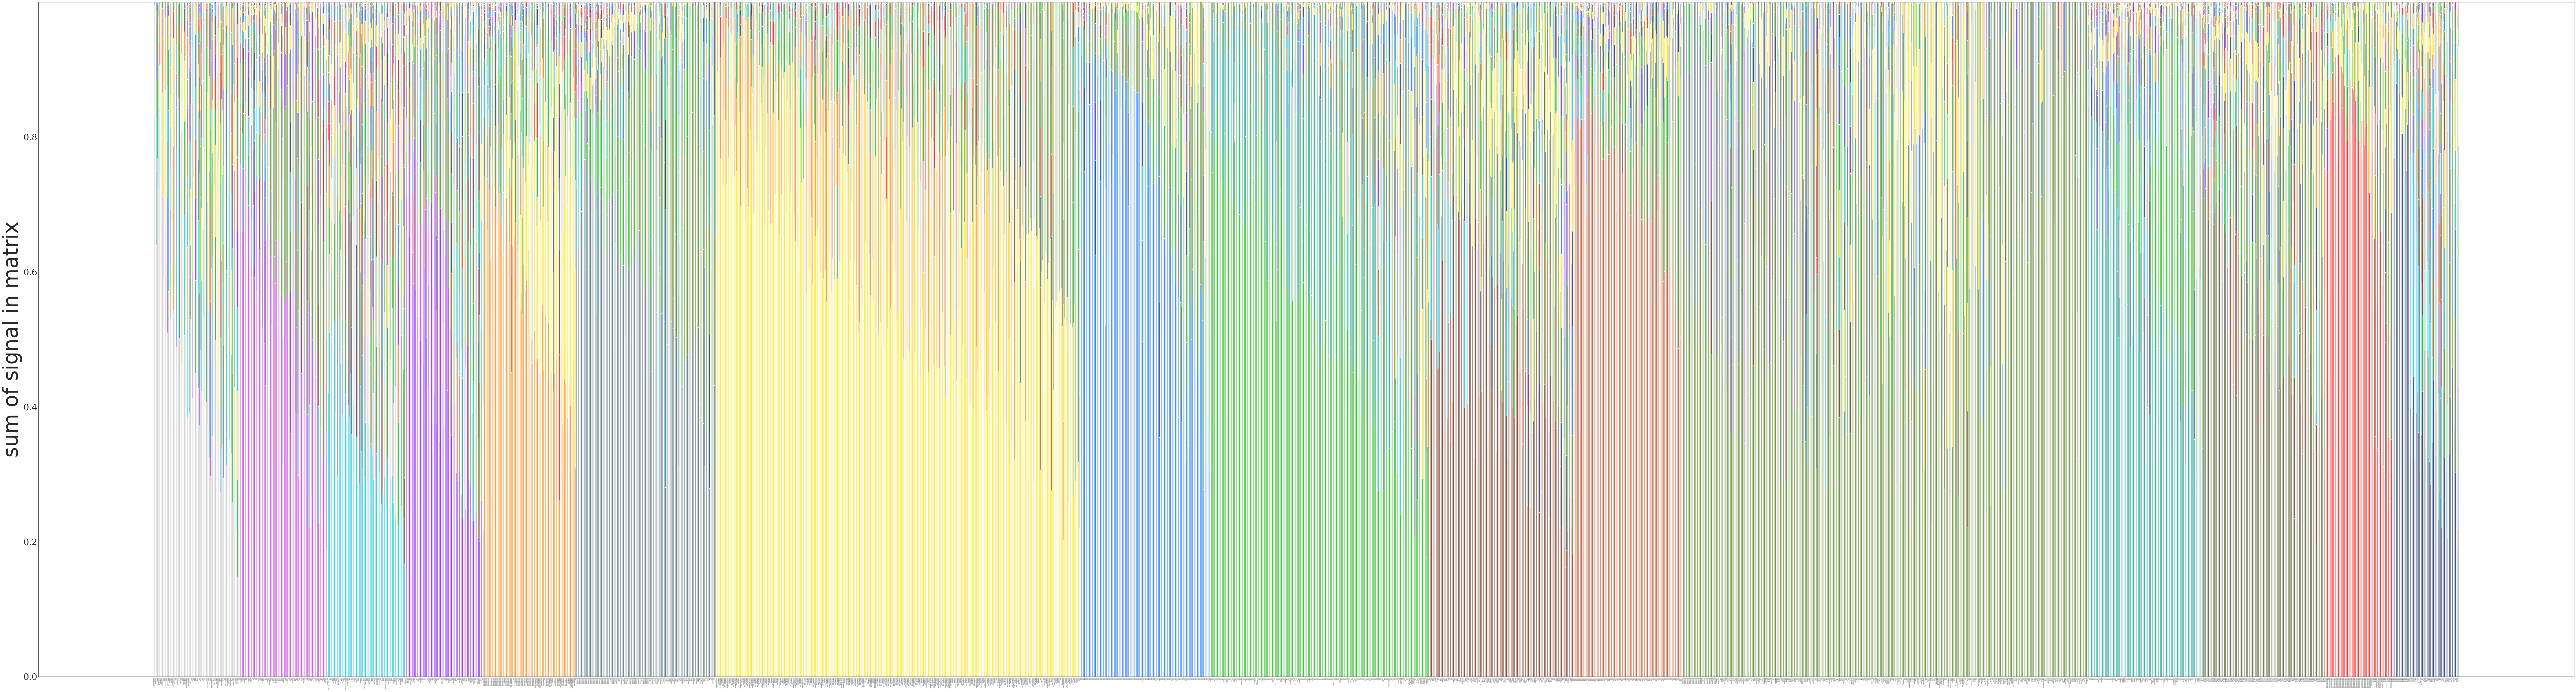

METHOD:  unweight  N_components:  24
(3780, 24) (24, 4230461) matrixes loaded for n_components 24


<Figure size 640x480 with 0 Axes>

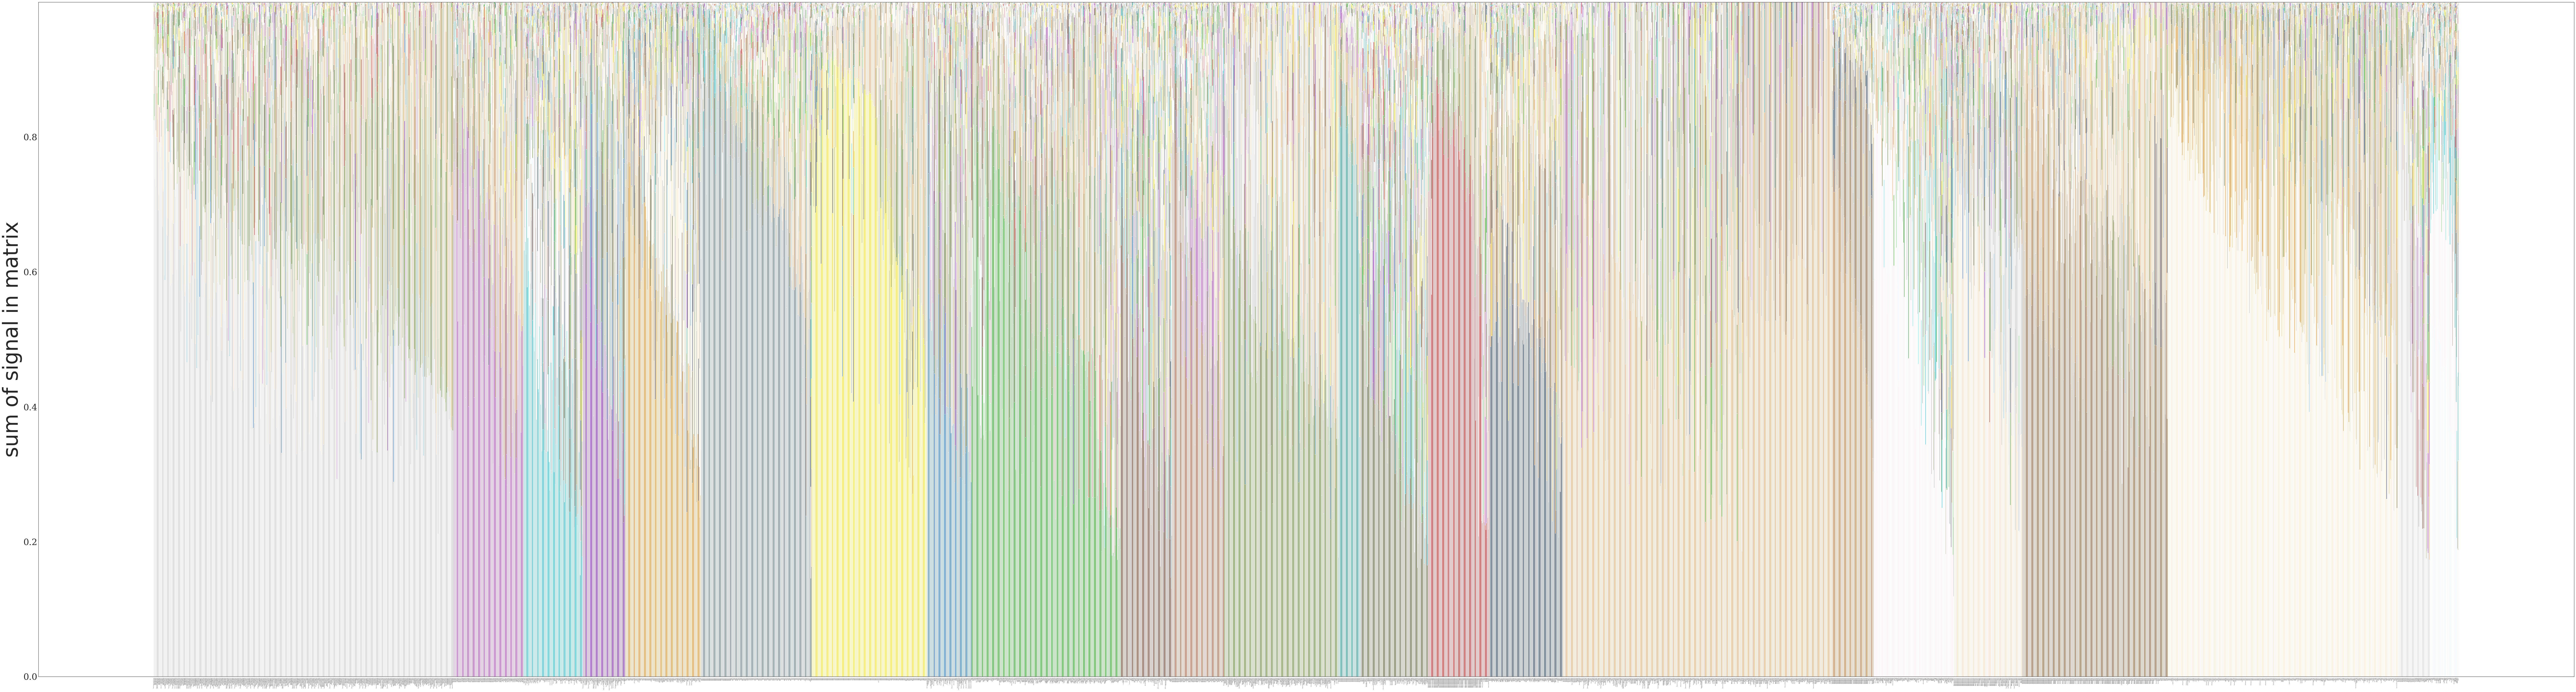

In [15]:
data_slice_size = "full"
methods_range = ["unweight"]
NC_ar = [16, 24]

for method in methods_range:
    for n_components in NC_ar:
        print("METHOD: ", method, " N_components: ", n_components)
        
        prefix = "bin_new_" + method + "_" + str(data_slice_size)+'.'+ str(n_components)
        
        # Data loading
        decomp = OONMF.NMFobject(n_components)
        decomp.matrix_input_name(dir_path_pipeline + prefix +'.W.npy', 
                                 dir_path_pipeline + prefix +'.H.npy')
        decomp.read_matrix_input(compressed=False)
        print(decomp.Basis.shape, decomp.Mixture.shape, "matrixes loaded for n_components", n_components)
        
        decomp.normalize_matrices()
        bar_graph_sort_order = get_barsortorder(decomp.Basis)
        decomp.define_colors()

        # Normolized stacked barplot
        decomp.make_stacked_bar_plot_sorted(decomp.Basis.shape[0], 
                         decomp.NormedBasis.T, 
                         dir_path_figures + prefix + '.stacked_bar_plot.normed.pdf', 
                         names=np.array(allnames), 
                         barsortorder=bar_graph_sort_order)

        